In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [3]:
# load each tsv in data/ into dataframes
dataframes = {}
for file in os.listdir('data/'):
    if file.endswith('.tsv'):
        dataframes[file.replace('.tsv','')] = pd.read_csv('data/' + file, sep='\t')
    elif file.endswith('.csv'):
        dataframes[file.replace('.csv','')] = pd.read_csv('data/' + file)

In [4]:
# load protected_colunmns.json into dict
import json
with open('protected_columns.json') as f:
    protected_columns = json.load(f)
    

In [114]:
from itertools import chain, combinations
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def calculate_group_sizes(df, protected_columns, num_protected_columns=3):
    """
    Calculates group sizes for protected classes in a dataframe.
    """

    df = df[df.columns[~df.isnull().any()]]

    # Get the powersets of all column combinations
    vectors = []
    for cols in list(powerset(protected_columns[:num_protected_columns])):
        if len(cols) >= 1:
            # NOTE: broken for texas due to non-numeric category in data
            # print(df.groupby(list(cols)).size().reset_index(name='counts'))
            vector = (df.groupby(list(cols)).size().reset_index(name='counts') / len(df))['counts'].values
            vectors.append(vector)
    
    with_shape = [(v, v.shape[0]) for v in vectors]
    vector_df = pd.DataFrame.from_records(with_shape, columns =['vector', 'shape'])
    vector_df = vector_df.groupby('shape').agg({'vector':lambda x: list(x)}).reset_index()

    # df = df[df.apply(lambda x: len(x['vector']) > 1, axis=1)]
    vector_df = vector_df[(vector_df['shape'] > 3) & (vector_df['shape'] <= 50)]
    return vector_df

In [115]:
vector_df = calculate_group_sizes(dataframes['saw2018cross'], protected_columns['saw2018cross'])
vector_df

,shape,vector
1,4,"[[0.25012350558245233, 0.24987649441754767, 0...."
2,6,"[[0.5598261041399071, 0.09806343246714752, 0.1..."
3,8,"[[0.12464183381088825, 0.12548167177156408, 0...."
4,12,"[[0.2814445212923624, 0.050044462009682836, 0...."
5,24,"[[0.09781642130224286, 0.14213022428613772, 0...."
6,48,"[[0.04880940618515957, 0.07020057306590258, 0...."


In [116]:
# Bootstrap calculate group sizes by resampling each dataframe
# with replacement
import random
def bootstrap_calculate_group_sizes(datasets, B=100):
    dataset_vectors = {}
    for dataset in datasets:
        df = datasets[dataset]
        agg_df = pd.DataFrame(columns=['shape','vector'])
        for _ in range(B):
            df_b = df.sample(n=len(df), replace=True)
            new_vectors = calculate_group_sizes(df_b, protected_columns[dataset])
            if len(agg_df) == 0:
                agg_df = new_vectors
            else:
                # merge new_vectors lists into agg_df
                agg_df = pd.merge(agg_df, new_vectors, on='shape', sort=False)
                agg_df['vector'] = agg_df['vector_x'] + agg_df['vector_y']
                agg_df = agg_df.drop(['vector_x','vector_y'],axis=1)
                
        dataset_vectors[dataset] = agg_df
    return dataset_vectors

dataset_vectors = bootstrap_calculate_group_sizes({'saw2018cross': dataframes['saw2018cross']})

def shuf_vecs(row):
    all_vecs = row['vector']
    row['vector'] = [random.sample(list(x), k=len(x)) for x in all_vecs]
    return row

dataset_vectors['saw2018cross'] = dataset_vectors['saw2018cross'].apply(lambda x: shuf_vecs(x), axis=1)

0.05882352941176471


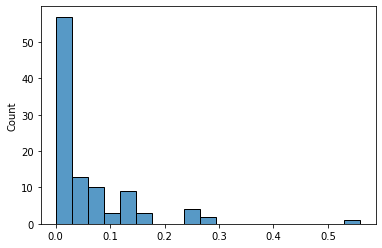

In [117]:
def plot_histogram_group_sizes(vector_df):
    """
    Plots group sizes for protected classes in a dataframe.
    """
    vectors_size = {}
    def app(row):
        arr = row['vector']
        if row['shape'] not in vectors_size:
            vectors_size[row['shape']] = []
        for vec in arr:
            vectors_size[row['shape']].append(vec.tolist())
    _ = vector_df.apply(lambda row: app(row), axis=1)
    all_group_sizes = []
    for s, vectors in vectors_size.items():
        for v in vectors:
            [all_group_sizes.append(item) for item in v]
    sns.histplot(all_group_sizes)
    print(np.mean(all_group_sizes))

plot_histogram_group_sizes(vector_df=vector_df)


https://github.com/ericsuh/dirichlet/blob/master/test/test_dirichlet.py
pip install git+https://github.com/ericsuh/dirichlet.git

In [118]:
import dirichlet

def fit_dir(row):
    vector = np.array(row['vector'])
    fp_alphas = dirichlet.mle(vector, method='fixedpoint')
    # mp_alphas = dirichlet.mle(vector, method='meanprecision')
    fp_log = dirichlet.loglikelihood(vector, fp_alphas)
    # mp_log = dirichlet.loglikelihood(vector, mp_alphas)
    dict_of_alphas = {
        'fp_alphas': fp_alphas,
        'fp_log': fp_log,
        # 'mp_alphas': mp_alphas,
        # 'mp_log': mp_log
    }
    return dict_of_alphas

alphas_likelihoods = dataset_vectors['saw2018cross'].apply(lambda row: fit_dir(row), axis=1)
print(alphas_likelihoods[1])
# all_alphas = []
# all_lls = []
# for row in alphas_likelihoods:
#     add = []
#     l_l = []
#     add.append(row[0]), add.append(row[2])
#     l_l.append(row[1]), l_l.append(row[3])
#     all_alphas.append([a for l in add for a in l])
#     all_lls.append(l_l)

# all_alphas = [[a] for l in all_alphas for a in l]
# all_lls = [[a] for l in all_lls for a in l]
# plot_alphas = pd.DataFrame.from_records(all_alphas, columns =['alphas'])
# plot_lls = pd.DataFrame.from_records(all_lls, columns =['likelihood'])
# plot_alphas.hist(range=(0, 100), bins=100)

{'fp_alphas': array([0.91197911, 0.87173227, 0.87478507, 0.92536224, 0.89356857,
       0.91312962]), 'fp_log': 481.03849536196105}


In [119]:
print(alphas_likelihoods[1])

{'fp_alphas': array([0.91197911, 0.87173227, 0.87478507, 0.92536224, 0.89356857,
       0.91312962]), 'fp_log': 481.03849536196105}


In [ ]:
all_alphas = []
all_lls = []
for row in alphas_likelihoods:
    add = []
    l_l = []
    add.append(row[0]), add.append(row[2])
    l_l.append(row[1]), l_l.append(row[3])
    all_alphas.append([a for l in add for a in l])
    all_lls.append(l_l)

all_alphas = [[a] for l in all_alphas for a in l]
all_lls = [[a] for l in all_lls for a in l]
plot_alphas = pd.DataFrame.from_records(all_alphas, columns =['alphas'])
plot_lls = pd.DataFrame.from_records(all_lls, columns =['likelihood'])

array([[<AxesSubplot:title={'center':'alphas'}>]], dtype=object)

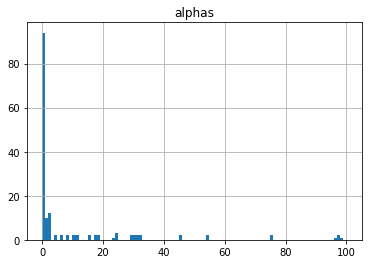

In [ ]:
plot_alphas.hist(range=(0, 100), bins=100)

In [7]:
# log range array np
import numpy as np
print(np.round(np.logspace(-2, 2, 9), 1))


[  0.    0.    0.1   0.3   1.    3.2  10.   31.6 100. ]
